Lo prmiero que hay que ahcer, creamos dos pipelines, en las dos cargamos el csv, en una pasamos las columna de varaibles categoricas a ordinalidad, en la otra hacemos un one hot encoding. (El one hto encodigin es malillo porque perdemos la informacion de de cual es mas caliente o frio y la distantcion entre la que estas, mejor es usar la ordinalidad).Luego en ambas hacemos un Pca, hay que hacer pca con parametros de 95% de la varianza de los datos. Y ya despues clustering.

## Recuerda que el random seed tiene que ser igual a un NIA (NO OLVIDAR)

La primera parte consta de crear nuestro propio metodo kmeans para ellos hay que implementar los siguientes metodos que son esenciales: inicializar centroides (porque), assign clusters (porque), update centroide (porque) y por ultimo el metodo en si de kmeans(porque). Luego para medir como de eficiente es nuestro modelo con el kmeans original usaremos el metdo make_blobs para crear un ejemplo bascio al que asociar cluster. Luego usaramos la metricas de tiempo y silhoutte score para comparar resultados. Problemas quen nos han surguido: Al usar un cluster_std=1.0 que es una estandaracicacion mjy junto es dependediente de el caso de como se inicialicen los centroides. Es por eso que a veces no me lo hacia conrrectamente de primeras tal y como lo tenia planteado sckitlearn. Para ellos hemos añadado a nuestra funcion inicialiazr cetrnoides la froma kmeans++ (porque) y de esta manera nuestro kmeans mejor bastante. 

Comparación entre k-means personalizado y scikit-learn:
Tiempo de ejecución (personalizado): 0.0019958019256591797 segundos
Silhouette score (personalizado): 0.7915830011443039
Tiempo de ejecución (scikit-learn): 0.0059223175048828125 segundos
Silhouette score (scikit-learn): 0.7915830011443039


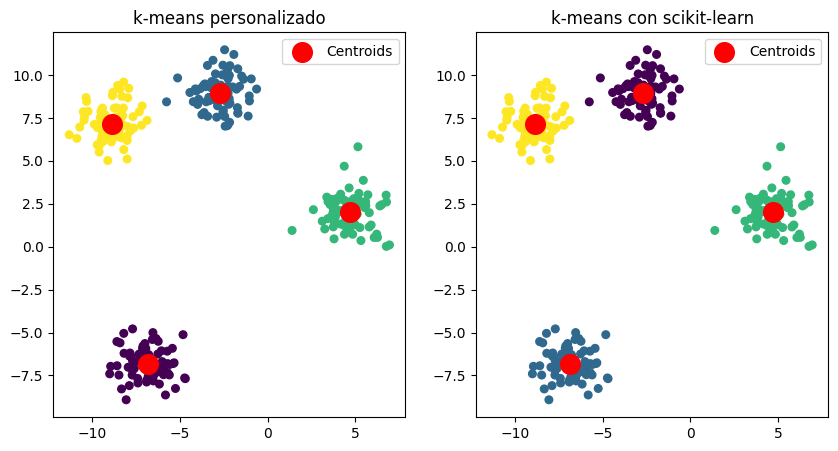

In [55]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time

# Crear datos de ejemplo
num_samples = 300
num_features = 2
num_clusters = 4

data, _ = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=1.0, random_state=42)

# Elegir centros iniciales aleatorios
def initialize_centroids(data, k):
    # Escoger el primer centroide al azar
    centroids = [data[random.randint(0, len(data) - 1)]]

    # Escoger el resto de los centroides usando el método K-Means++
    for _ in range(1, k):
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(range(len(data)), p=probabilities)
        centroids.append(data[new_centroid_index])

    return np.array(centroids)

# Asignar puntos a los clústeres
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Actualizar los centros de los clústeres
def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# Función para el algoritmo k-means
def kmeans(data, k, num_iterations=10000, tolerance=1e-4):

    centroids = initialize_centroids(data, k)

    for _ in range(num_iterations):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # Chequeo de convergencia
        if np.linalg.norm(centroids - new_centroids) < tolerance:
            break

        centroids = new_centroids

    return centroids, labels


#Comparación entre k-means personalizado y scikit-learn
start_time = time.time()
centroids_custom, labels_custom = kmeans(data, num_clusters)
custom_time = time.time() - start_time
silhouette_custom = silhouette_score(data, labels_custom)

start_time = time.time()
sklearn_kmeans = SKLearnKMeans(n_clusters=num_clusters, random_state=42).fit(data)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
sklearn_time = time.time() - start_time
silhouette_sklearn = silhouette_score(data, labels_sklearn)

# Mostrar resultados
print("Comparación entre k-means personalizado y scikit-learn:")
print("Tiempo de ejecución (personalizado):", custom_time, "segundos")
print("Silhouette score (personalizado):", silhouette_custom)

print("Tiempo de ejecución (scikit-learn):", sklearn_time, "segundos")
print("Silhouette score (scikit-learn):", silhouette_sklearn)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("k-means personalizado")
plt.scatter(data[:, 0], data[:, 1], c=labels_custom, cmap='viridis', s=30)
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], c='red', s=200, label='Centroids')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("k-means con scikit-learn")
plt.scatter(data[:, 0], data[:, 1], c=labels_sklearn, cmap='viridis', s=30)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], c='red', s=200, label='Centroids')
plt.legend()


plt.show()

# Preprocesado

Primero cargamos el csv y realizamos los ajutes necesarios. Primero visualizar los datos y aquellas varaibles categoricas visualizarlas y ver que datos tienen

In [62]:
# Importar las librerías necesarias
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Crear un dataframe de ejemplo
df = pd.read_csv("Stars2.csv")  # Aquí cargas tu archivo CSV
unique_colors = df['Color'].unique()
unique_spectral_classes = df['Spectral_Class'].unique()

print("Clases únicas para 'color':", unique_colors)
print("Clases únicas para 'Spectral_class':", unique_spectral_classes)
# Definir columnas categóricas
categorical_columns = ['color', 'Spectral_Class']

# Valores de ejemplo para OrdinalEncoder
df.head()


Clases únicas para 'color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Clases únicas para 'Spectral_class': ['M' 'B' 'A' 'F' 'O' 'K' 'G']


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Una vez visto que colo no tiene buenos colores o lagunos son los mimso pero con distinto nombres pues le aplicamos un color mappin para restrucutrar los datos, a su vez vemos los datos faltantes al mas puro prepocesado basico

In [63]:
color_mapping = {
    "Blue White": "Blue-White",
    "Blue white": "Blue-White",
    "Blue-white": "Blue-White",
    "White-Yellow": "White-Yellow",
    "yellow-white": "White-Yellow",
    "yellowish": "Yellowish",
	"white": "White",
}
# Aplicar el mapeo a la columna de color
df["Color"] = df["Color"].replace(color_mapping)

# Obtener las nuevas clases únicas para verificar la fusión
unique_colors = df["Color"].unique()
print("Clases únicas después de fusionar similares:", unique_colors)

Clases únicas después de fusionar similares: ['Red' 'Blue-White' 'White' 'Yellowish White' 'Pale yellow orange' 'Blue'
 'Whitish' 'White-Yellow' 'Orange' 'Yellowish' 'Orange-Red']


In [64]:
print("Número de instancias y características:")
print(df.shape)
print("Valores faltantes:")
print(df.isnull().sum())
constantes = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes:")
print(constantes)

Número de instancias y características:
(240, 6)
Valores faltantes:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64
Columnas constantes:
[]


Vamos a crear las distintos dataframes con las 4 posibles combinaciones de cambios de colummnas para cambiar als variables categoricas. Estos son: crear las distintas pipelines con las distintas columna categoricas para pasarlas respectivamente a ordinaliad o one hot encoding

In [65]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder



# Definir el orden para el OrdinalEncoder
color_order = ["Red", "Orange-Red", "Orange", "Pale yellow orange", 
               "Yellowish", "Yellowish White", "White", 
               "Whitish", "White-Yellow", "Blue-White", "Blue"]

spectral_class_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Crear un OrdinalEncoder con orden específico
ordinal_encoder = OrdinalEncoder(categories=[color_order, spectral_class_order])

# Aplicar OrdinalEncoder a las columnas categóricas
df_ordinal = df.copy()
df_ordinal[['Color', 'Spectral_Class']] = ordinal_encoder.fit_transform(df[['Color', 'Spectral_Class']])

# Mostrar el DataFrame con valores ordinales
print("DataFrame con columnas categóricas convertidas a ordinalidad:")
df_ordinal.head()


DataFrame con columnas categóricas convertidas a ordinalidad:


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,6.0
1,3042,0.000500,0.1542,16.60,0.0,6.0
2,2600,0.000300,0.1020,18.70,0.0,6.0
3,2800,0.000200,0.1600,16.65,0.0,6.0
4,1939,0.000138,0.1030,20.06,0.0,6.0


In [66]:
# Crear el dataframe con One-Hot Encoding
df_one_hot = pd.get_dummies(df.copy(), columns=['Color', 'Spectral_Class'])

# Convertir las columnas booleanas a valores 0 y 1
df_one_hot = df_one_hot.astype(int)

print("DataFrame con One-Hot Encoding usando 0 y 1:")
df_one_hot.head()



DataFrame con One-Hot Encoding usando 0 y 1:


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,...,Color_Whitish,Color_Yellowish,Color_Yellowish White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [67]:
# Ordinalidad para "color"
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[color_order])

df_oc_ohes = df.copy()
df_oc_ohes['Color'] = ordinal_encoder.fit_transform(df[['Color']])

# One-Hot Encoding para "Spectral_class"
df_oc_ohes = pd.get_dummies(df_oc_ohes, columns=['Spectral_Class'])

# Convertir booleanos a ceros y unos
df_oc_ohes = df_oc_ohes.astype(int)

print("DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:")
df_oc_ohes.head()



DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:


,Temperature,L,R,A_M,Color,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,0,1,0


In [68]:
# One-Hot Encoding para "color"
df_ohec_os = pd.get_dummies(df, columns=['Color'])

ordinal_encoder = OrdinalEncoder(categories=[spectral_class_order])
# Ordinalidad para "Spectral_class"
df_ohec_os['Spectral_Class'] = ordinal_encoder.fit_transform(df[['Spectral_Class']])

# Convertir booleanos a ceros y unos
df_mixed_2 = df_ohec_os.astype(int)

print("DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:")
df_mixed_2.head()


DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:


,Temperature,L,R,A_M,Spectral_Class,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,Color_White,Color_White-Yellow,Color_Whitish,Color_Yellowish,Color_Yellowish White
0,3068,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
1,3042,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
2,2600,0,0,18,6,0,0,0,0,0,1,0,0,0,0,0
3,2800,0,0,16,6,0,0,0,0,0,1,0,0,0,0,0
4,1939,0,0,20,6,0,0,0,0,0,1,0,0,0,0,0


In [70]:
import pandas as pd
from sklearn.decomposition import PCA

# Supongamos que ya tienes df_mixed_1 y df_mixed_2 después de las transformaciones anteriores

# Aplicar PCA con 2 componentes
pca = PCA(n_components=2)

# Aplicar PCA al primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
df_mixed_1_pca = pca.fit_transform(df_oc_ohes)

# Convertir el resultado a DataFrame para visualización
df_mixed_1_pca_df = pd.DataFrame(df_mixed_1_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el primer DataFrame:")
print(df_mixed_1_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_mixed_2_pca = pca.fit_transform(df_ohec_os)

# Convertir el resultado a DataFrame para visualización
df_mixed_2_pca_df = pd.DataFrame(df_mixed_2_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el segundo DataFrame:")
print(df_mixed_2_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_ordinal_pca = pca.fit_transform(df_ordinal)

# Convertir el resultado a DataFrame para visualización
df_ordinal_pca_df = pd.DataFrame(df_ordinal_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el tercer DataFrame:")
print(df_ordinal_pca_df.head())

# Aplicar PCA al segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
df_one_hot_pca = pca.fit_transform(df_one_hot)

# Convertir el resultado a DataFrame para visualización
df_one_hot_pca_df = pd.DataFrame(df_one_hot_pca, columns=["PCA_Component_1", "PCA_Component_2"])

print("Resultados de PCA para el cuarto DataFrame:")
print(df_one_hot_pca_df.head())


Resultados de PCA para el primer DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895126     -5177.123364
1   -107321.440846     -5203.116539
2   -107330.718158     -5645.000863
3   -107326.520237     -5445.053008
4   -107344.592110     -6305.827695
Resultados de PCA para el segundo DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.921006     -5177.121793
1   -107321.468668     -5203.114876
2   -107330.746268     -5644.998791
3   -107326.548353     -5445.051420
4   -107344.620358     -6305.825578
Resultados de PCA para el segundo DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.921035     -5177.122876
1   -107321.468698     -5203.115957
2   -107330.746298     -5644.999839
3   -107326.548382     -5445.052483
4   -107344.620387     -6305.826578
Resultados de PCA para el segundo DataFrame:
   PCA_Component_1  PCA_Component_2
0   -107320.895097     -5177.122282
1   -107321.440817     -5203.115458
2   -107330.718129     -5644.999815
3   -107326.520207     -5445.

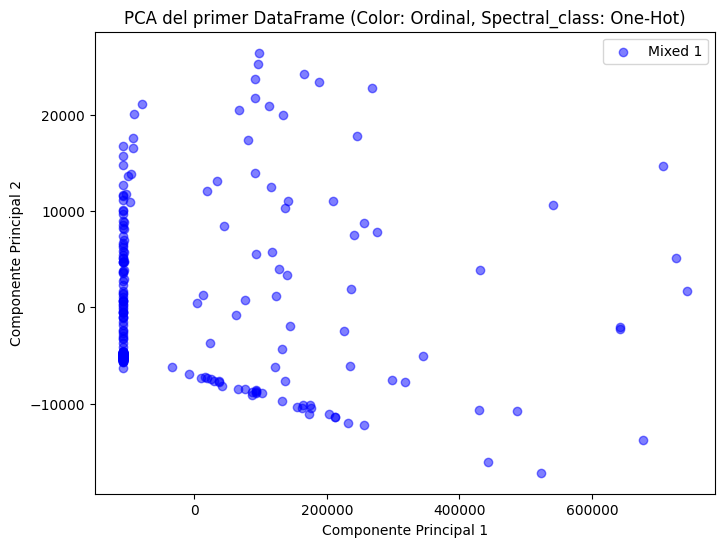

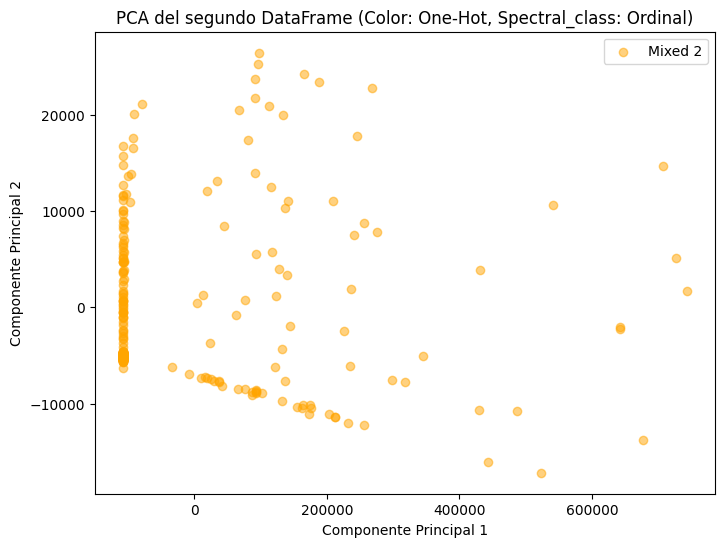

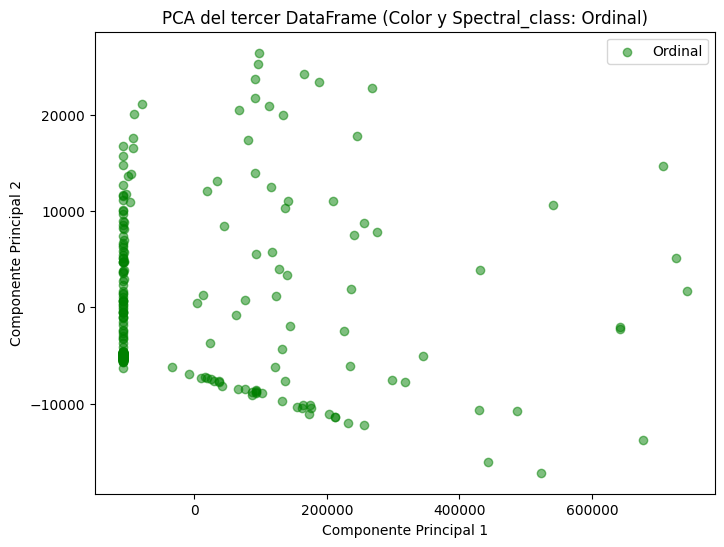

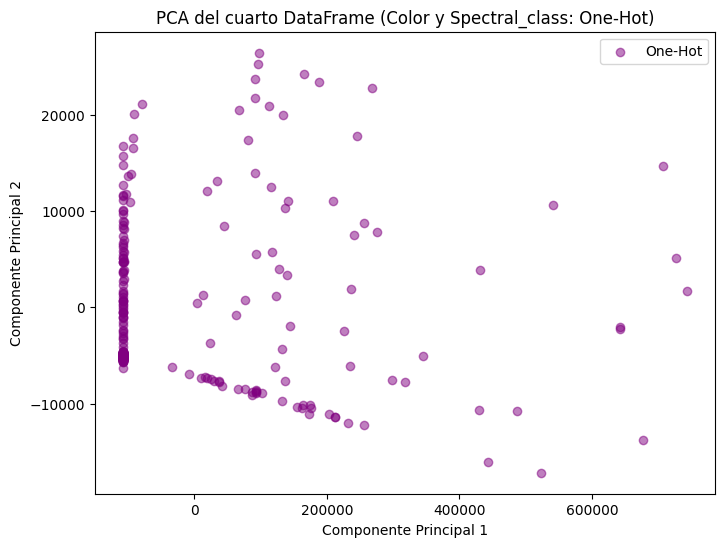

In [71]:
import matplotlib.pyplot as plt

# Gráfico para el primer DataFrame (color en ordinalidad, Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_1_pca_df["PCA_Component_1"], df_mixed_1_pca_df["PCA_Component_2"], c='blue', alpha=0.5, label='Mixed 1')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del primer DataFrame (Color: Ordinal, Spectral_class: One-Hot)")
plt.legend()
plt.show()

# Gráfico para el segundo DataFrame (color en One-Hot Encoding, Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_mixed_2_pca_df["PCA_Component_1"], df_mixed_2_pca_df["PCA_Component_2"], c='orange', alpha=0.5, label='Mixed 2')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del segundo DataFrame (Color: One-Hot, Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el tercer DataFrame (color y Spectral_class en ordinalidad)
plt.figure(figsize=(8, 6))
plt.scatter(df_ordinal_pca_df["PCA_Component_1"], df_ordinal_pca_df["PCA_Component_2"], c='green', alpha=0.5, label='Ordinal')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del tercer DataFrame (Color y Spectral_class: Ordinal)")
plt.legend()
plt.show()

# Gráfico para el cuarto DataFrame (color y Spectral_class en One-Hot Encoding)
plt.figure(figsize=(8, 6))
plt.scatter(df_one_hot_pca_df["PCA_Component_1"], df_one_hot_pca_df["PCA_Component_2"], c='purple', alpha=0.5, label='One-Hot')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PCA del cuarto DataFrame (Color y Spectral_class: One-Hot)")
plt.legend()
plt.show()


Quizas despues de ver este resutlado, deberia hacer una tresta para ver al diferencia entre one hot encoding y ordinalidad.
Para ver si realmente hay muchis cambios. Una opcion posible de este caso y que entre todas las graficas se aprezca muhco es porque quizas estos dos parametros de color y spectral class no afectan mucho a la varianza y da un poco igual. Tambien una cosa que me dijo el profe es que haga un scaler de los datos a ver que tal.